In [1]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import iris
import xesmf as xe

In [2]:
def regrid(ds_in, ds_out, var, method='bilinear'):
    regridder = xe.Regridder(ds_in, ds_out, method, periodic=True,ignore_degenerate=True)
    dr_out = regridder(ds_in[var])
    return dr_out

In [3]:
# read in lana ancillary and convert to xarray 
fname = '/g/data/jk72/slf563/ACCESS/ANCIL/qrclim.sulpdms'
lana =iris.load_cube(fname)
lanax = xr.DataArray.from_iris(lana)

/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/iris/fileformats/pp.py:1597: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  self._t2 = cftime.datetime(
/g/data/hh5/public/apps/miniconda3/envs/analysis3-22.07/lib/python3.9/site-packages/cf_units/__init__.py:402: UserWarning: has_year_zero kwarg ignored for idealized calendars (always True)
  dates = np.array([dt and dt.replace(microsecond=0) for dt in dates])


In [4]:
# copy lana grid 
ds_out = xr.Dataset({"latitude": (["latitude"], lanax.latitude.values),
                     "longitude": (["longitude"], lanax.longitude.values),})

# get lsmask from the original lana ancillary  
lsmask = lanax.where(lanax==0,1).mean('time')
lsmask = lsmask.where(lsmask==1,np.nan)
lsmask = lsmask.rename('lsmask')

In [5]:
# read new climatology 
fname = '/g/data/jk72/slf563/ACCESS/ANCIL/DMS_REV3.nc'
dmsRev3 = xr.open_mfdataset(fname)

In [6]:
DMSRev3N96 = regrid(dmsRev3, ds_out, 'DMS') # regrid to N96 mask 
DMSRev3N96ls = DMSRev3N96.interpolate_na(dim='longitude')*lsmask # interpolate accross longitudes to fill the nans, 
                                                                 # and then apply original land sea mask 
DMSRev3N96ls = DMSRev3N96ls.where(DMSRev3N96ls.notnull(),0) # fill nans with zeros 

In [7]:
# provide meta data
DMSRev3N96ls = DMSRev3N96ls.rename({'month':'time'})
DMSRev3N96ls['time'] = DMSRev3N96ls.time.assign_attrs({'standard_name':'time'})
DMSRev3N96ls['longitude'] = DMSRev3N96ls.longitude.assign_attrs({'standard_name':'longitude', 'units':'degrees'})
DMSRev3N96ls['latitude'] = DMSRev3N96ls.latitude.assign_attrs({'standard_name':'latitude', 'units':'degrees'})
DMSRev3N96ls = DMSRev3N96ls.assign_attrs({'units':'nanomole/l', 
                                     'standard_name':'mole_concentration_of_dimethyl_sulfide_in_sea_water',
                                     'source':'DMS climatology from Hulswar et al. (2022) https://doi.org/10.5194/essd-14-2963-2022. Data available from https://doi.org/10.17632/hyn62spny2.1',
                                     'history':'Regridded by S.Fiddes (sonya.fiddes@utas.edu.au) for the N96 grid and appropriate UM land-sea mask'})

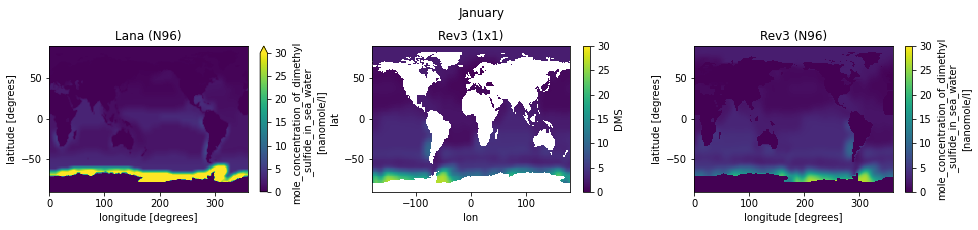

In [8]:
fig = plt.figure(figsize=(16,3))
ax = plt.subplot(131)
lanax[0,:,:].plot(vmin=0,vmax=30);
ax.set_title('Lana (N96)');

ax = plt.subplot(132)
dmsRev3['DMS'][0,:,:].T.plot(vmin=0,vmax=30)
ax.set_title('Rev3 (1x1)');

ax = plt.subplot(133)
DMSRev3N96ls[0,:,:].plot(vmin=0,vmax=30)
ax.set_title('Rev3 (N96)');

plt.suptitle('January',)

plt.subplots_adjust(wspace=0.3,top=0.8)

In [9]:
DMSRev3N96ls.to_netcdf('/g/data/jk72/slf563/ACCESS/ANCIL/DMS_Rev3_N96.nc')
# Will use XAncil to convert to pp file instead of iris 